In [5]:
from PIL import Image
import os

# === Config ===
image_path = "input_data/X_test/"  # Đường dẫn đến ảnh gốc
ROWS = 3
COLS = 5

def split_image(image_path, rows, cols):
    """Đọc ảnh và cắt thành rows x cols, trả về danh sách các mảnh."""
    img = Image.open(image_path)
    width, height = img.size

    piece_width = width // cols
    piece_height = height // rows

    pieces = []
    for r in range(rows):
        for c in range(cols):
            left = c * piece_width
            upper = r * piece_height
            right = left + piece_width
            lower = upper + piece_height
            piece = img.crop((left, upper, right, lower))
            pieces.append(piece)

    return pieces

def load_all_pieces(image_dir, rows, cols):
    """
    Duyệt toàn bộ ảnh trong thư mục và trả về mảng 3 chiều:
    all_pieces[image_index][row][col] = PIL.Image
    """
    all_pieces = []
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    )

    print(f"Found {len(image_files)} images in {image_dir}")

    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        print(f"- Processing {filename}...")
        pieces = split_image(image_path, rows, cols)
        all_pieces.append(pieces)

    print(f"\nTotal images processed: {len(all_pieces)}")
    return all_pieces

all_pieces = load_all_pieces(image_path, ROWS, COLS)
# if DEBUG:
#     all_pieces = all_pieces[:20]  # Giới hạn để debug nhanh

# Ví dụ: xem thông tin
print(f"Total images: {len(all_pieces)}")  # số lượng ảnh
if all_pieces:
    print(f"Rows per image: {len(all_pieces[0])}")


Found 100 images in input_data/X_test/
- Processing Alfred_Sisley_115_shuffled.jpg...
- Processing Alfred_Sisley_188_shuffled.jpg...
- Processing Alfred_Sisley_205_shuffled.jpg...
- Processing Alfred_Sisley_232_shuffled.jpg...
- Processing Alfred_Sisley_6_shuffled.jpg...
- Processing Amedeo_Modigliani_112_shuffled.jpg...
- Processing Amedeo_Modigliani_143_shuffled.jpg...
- Processing Amedeo_Modigliani_2_shuffled.jpg...
- Processing Amedeo_Modigliani_65_shuffled.jpg...
- Processing Amedeo_Modigliani_73_shuffled.jpg...
- Processing Andrei_Rublev_32_shuffled.jpg...
- Processing Andrei_Rublev_50_shuffled.jpg...
- Processing Andrei_Rublev_89_shuffled.jpg...
- Processing Andy_Warhol_11_shuffled.jpg...
- Processing Andy_Warhol_161_shuffled.jpg...
- Processing Andy_Warhol_171_shuffled.jpg...
- Processing Andy_Warhol_70_shuffled.jpg...
- Processing Andy_Warhol_88_shuffled.jpg...
- Processing Camille_Pissarro_3_shuffled.jpg...
- Processing Caravaggio_19_shuffled.jpg...
- Processing Caravaggio_22

In [6]:

def invert_perm_c2o_to_o2c(c2o):
    """c2o[c]=o  ->  o2c[o]=c"""
    n = len(c2o)
    o2c = [0]*n
    for c, o in enumerate(c2o):
        o2c[o] = c
    return o2c

def invert_perm_o2c_to_c2o(o2c):
    """o2c[o]=c  ->  c2o[c]=o"""
    n = len(o2c)
    c2o = [0]*n
    for o, c in enumerate(o2c):
        c2o[c] = o
    return c2o

In [7]:
# === Single cell: Advanced fitness + solver + demo ===
import os, csv, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========= Helpers =========
def _to_np_rgb(pil_img):
    return np.asarray(pil_img.convert("RGB"), dtype=np.float32)

def _to_gray(arr_rgb):
    # simple luminance
    return np.mean(arr_rgb, axis=2).astype(np.float32)

def _grad_mag(gray):
    # gradient magnitude via np.gradient (Sobel-free, no extra deps)
    gy, gx = np.gradient(gray)
    return np.hypot(gx, gy).astype(np.float32)

def _border_arrays_rgb_and_grad(pieces):
    arrs = [_to_np_rgb(p) for p in pieces]
    grays = [_to_gray(a) for a in arrs]
    grads = [_grad_mag(g) for g in grays]

    # RGB borders (H,W,3)
    tops    = [a[0, :, :]  for a in arrs]
    bottoms = [a[-1, :, :] for a in arrs]
    lefts   = [a[:, 0, :]  for a in arrs]
    rights  = [a[:, -1, :] for a in arrs]

    # Gradient borders (H,W) -> 1D slices
    tops_g    = [g[0, :]  for g in grads]
    bottoms_g = [g[-1, :] for g in grads]
    lefts_g   = [g[:, 0]  for g in grads]
    rights_g  = [g[:, -1] for g in grads]

    return tops, bottoms, lefts, rights, tops_g, bottoms_g, lefts_g, rights_g

def _mse(a, b):
    L = min(a.shape[0], b.shape[0])
    if L <= 0: return 0.0
    diff = a[:L].astype(np.float32) - b[:L].astype(np.float32)
    return float(np.mean(diff * diff))

# ========= Advanced cost =========
def compute_cost_matrix_advanced(pieces, alpha=0.7, beta=0.3, use_symmetry=True, use_compat_ratio=True):
    """
    Trả về H, V là cost đặt j ở bên phải/dưới i.
    - Cost cơ sở: α * MSE_RGB + β * MSE_Gradient
    - Tùy chọn 'symmetry': làm mịn theo đối xứng i<->j (geometric mean)
    - Tùy chọn 'compat_ratio': chuẩn hoá theo lựa chọn tốt nhất của i (tỉ lệ >=1, càng nhỏ càng tốt)
    """
    n = len(pieces)
    H = np.zeros((n, n), dtype=np.float64)
    V = np.zeros((n, n), dtype=np.float64)

    (tops, bottoms, lefts, rights,
     tops_g, bottoms_g, lefts_g, rights_g) = _border_arrays_rgb_and_grad(pieces)

    # 1) cost cơ sở
    for i in range(n):
        r_i, b_i      = rights[i], bottoms[i]
        r_i_g, b_i_g  = rights_g[i], bottoms_g[i]
        for j in range(n):
            if i == j: 
                continue
            # Horizontal: right(i) vs left(j)
            cost_rgb_h  = _mse(r_i,  lefts[j])
            cost_grad_h = _mse(r_i_g, lefts_g[j])
            # Vertical: bottom(i) vs top(j)
            cost_rgb_v  = _mse(b_i,  tops[j])
            cost_grad_v = _mse(b_i_g, tops_g[j])

            H[i, j] = alpha*cost_rgb_h + beta*cost_grad_h
            V[i, j] = alpha*cost_rgb_v + beta*cost_grad_v

    # 2) đối xứng (khớp tốt phải "đồng thuận" hai chiều)
    if use_symmetry:
        # Geometric mean giữa H[i,j] và "cặp đối" H[j,i]
        # (khuyến khích cặp cạnh thật sự phù hợp ở cả hai hướng)
        with np.errstate(invalid='ignore'):
            H_sym = np.sqrt(np.maximum(H, 1e-12) * np.maximum(H.T, 1e-12))
            V_sym = np.sqrt(np.maximum(V, 1e-12) * np.maximum(V.T, 1e-12))
        # không đụng tới đường chéo
        np.fill_diagonal(H_sym, 0.0)
        np.fill_diagonal(V_sym, 0.0)
        H, V = H_sym, V_sym

    # 3) compatibility ratio (chuẩn hoá theo lựa chọn tốt nhất của i)
    if use_compat_ratio:
        # thay 0 bằng +inf để min bỏ qua i==j
        H_masked = np.where(H > 0, H, np.inf)
        V_masked = np.where(V > 0, V, np.inf)
        minH = np.min(H_masked, axis=1)  # best neighbor cho i (phải)
        minV = np.min(V_masked, axis=1)  # best neighbor cho i (dưới)
        for i in range(n):
            if np.isfinite(minH[i]) and minH[i] > 0:
                H[i, :] = np.where(H[i, :] > 0, H[i, :] / minH[i], 0.0)
            if np.isfinite(minV[i]) and minV[i] > 0:
                V[i, :] = np.where(V[i, :] > 0, V[i, :] / minV[i], 0.0)

    return H, V

# ========= Local Search Solver =========
class LocalSearchPuzzleSolver:
    def __init__(self, rows, cols, max_iters=1000, restarts=5, rng_seed=None, lambda_border=0.6):
        self.rows = rows
        self.cols = cols
        self.max_iters = max_iters
        self.restarts = restarts
        self.rng = random.Random(rng_seed)
        self.lambda_border = float(lambda_border)

    def _repair_perm(self, chrom):
        n = self.rows * self.cols
        used, out = set(), []
        for g in chrom:
            if isinstance(g, (int, np.integer)) and 0 <= g < n and g not in used:
                out.append(int(g)); used.add(int(g))
        out.extend([x for x in range(n) if x not in used])
        return out[:n]

    def _precompute_border_penalties(self, H, V):
        n = H.shape[0]
        BIG = 1e18
        H_nodiag = H + np.eye(n)*BIG
        V_nodiag = V + np.eye(n)*BIG
        # Với phía TRÁI của i: cần j ở bên trái -> dùng H[j,i]
        left_pen   = H_nodiag.min(axis=0)   # min_j H[j,i]
        # PHẢI của i: H[i,j]
        right_pen  = H_nodiag.min(axis=1)   # min_j H[i,j]
        # TRÊN của i: V[j,i]
        top_pen    = V_nodiag.min(axis=0)   # min_j V[j,i]
        # DƯỚI của i: V[i,j]
        bottom_pen = V_nodiag.min(axis=1)   # min_j V[i,j]
        return left_pen, right_pen, top_pen, bottom_pen

    def _fitness(self, chrom, H, V):
        total = 0.0
        grid = np.array(chrom, dtype=int).reshape(self.rows, self.cols)

        # Border penalties
        left_pen, right_pen, top_pen, bottom_pen = self._precompute_border_penalties(H, V)

        for r in range(self.rows):
            for c in range(self.cols):
                cur = grid[r, c]
                if c < self.cols - 1:
                    total += H[cur, grid[r, c+1]]
                else:
                    total += self.lambda_border * right_pen[cur]

                if r < self.rows - 1:
                    total += V[cur, grid[r+1, c]]
                else:
                    total += self.lambda_border * bottom_pen[cur]

                if c == 0:
                    total += self.lambda_border * left_pen[cur]
                if r == 0:
                    total += self.lambda_border * top_pen[cur]

        return float(total)

    def _random_chrom(self, n):
        base = list(range(n))
        self.rng.shuffle(base)
        return base

    def _best_improvement_swap_and_blockswap(self, chrom, H, V, base_fit):
        R, C = self.rows, self.cols
        best_neighbor, best_delta = None, 0.0
        n = len(chrom)

        # SWAP
        for i in range(n - 1):
            for j in range(i + 1, n):
                cand = chrom[:]
                cand[i], cand[j] = cand[j], cand[i]
                cand = self._repair_perm(cand)
                d = self._fitness(cand, H, V) - base_fit
                if d < best_delta:
                    best_delta, best_neighbor = d, cand

        # BLOCK-SWAP
        grid0 = np.array(chrom, dtype=int).reshape(R, C)
        for h in range(1, R + 1):
            for w in range(1, C + 1):
                positions = [(r, c) for r in range(0, R - h + 1)
                                   for c in range(0, C - w + 1)]
                m = len(positions)
                if m <= 1:
                    continue
                for a in range(m - 1):
                    r0, c0 = positions[a]
                    for b in range(a + 1, m):
                        r1, c1 = positions[b]
                        if r0 == r1 and c0 == c1:
                            continue
                        g = grid0.copy()
                        src = g[r0:r0+h, c0:c0+w].copy()
                        dst = g[r1:r1+h, c1:c1+w].copy()
                        g[r0:r0+h, c0:c0+w] = dst
                        g[r1:r1+h, c1:c1+w] = src
                        cand = self._repair_perm(g.reshape(-1).tolist())
                        d = self._fitness(cand, H, V) - base_fit
                        if d < best_delta:
                            best_delta, best_neighbor = d, cand
        return best_neighbor, best_delta

    def _best_improvement_one_with_two(self, chrom, H, V, base_fit):
        R, C = self.rows, self.cols
        grid0 = np.array(chrom, dtype=int).reshape(R, C)
        best_neighbor, best_delta = None, 0.0

        # Vertical "C,A,B"
        if R >= 3:
            cut_rows = [i for i in range(1, R)]
            for w in range(1, C + 1):
                for c0 in range(0, C - w + 1):
                    for a in range(len(cut_rows) - 1):
                        r1 = cut_rows[a]
                        for b in range(a + 1, len(cut_rows)):
                            r2 = cut_rows[b]
                            g = grid0.copy()
                            A = g[0:r1,        c0:c0+w].copy()
                            B = g[r1:r2,       c0:c0+w].copy()
                            Cbot = g[r2:R,     c0:c0+w].copy()
                            g[0:len(Cbot),                 c0:c0+w] = Cbot
                            g[len(Cbot):len(Cbot)+len(A),  c0:c0+w] = A
                            g[len(Cbot)+len(A):len(Cbot)+len(A)+len(B), c0:c0+w] = B
                            cand = self._repair_perm(g.reshape(-1).tolist())
                            d = self._fitness(cand, H, V) - base_fit
                            if d < best_delta:
                                best_delta, best_neighbor = d, cand

        # Horizontal "C,A,B"
        if C >= 3:
            cut_cols = [j for j in range(1, C)]
            for h in range(1, R + 1):
                for r0 in range(0, R - h + 1):
                    for a in range(len(cut_cols) - 1):
                        c1 = cut_cols[a]
                        for b in range(a + 1, len(cut_cols)):
                            c2 = cut_cols[b]
                            g = grid0.copy()
                            A = g[r0:r0+h, 0:c1      ].copy()
                            B = g[r0:r0+h, c1:c2     ].copy()
                            Cright = g[r0:r0+h, c2:C ].copy()
                            wC, wA, wB = Cright.shape[1], A.shape[1], B.shape[1]
                            g[r0:r0+h, 0:wC]                 = Cright
                            g[r0:r0+h, wC:wC+wA]             = A
                            g[r0:r0+h, wC+wA:wC+wA+wB]       = B
                            cand = self._repair_perm(g.reshape(-1).tolist())
                            d = self._fitness(cand, H, V) - base_fit
                            if d < best_delta:
                                best_delta, best_neighbor = d, cand
        return best_neighbor, best_delta

    def _best_improvement_step(self, chrom, H, V):
        base_fit = self._fitness(chrom, H, V)
        nb1, d1 = self._best_improvement_swap_and_blockswap(chrom, H, V, base_fit)
        nb2, d2 = self._best_improvement_one_with_two(chrom, H, V, base_fit)
        if nb1 is None and nb2 is None:
            return None, 0.0
        if nb1 is None or (nb2 is not None and d2 < d1):
            return nb2, d2
        return nb1, d1

    def run(self, pieces):
        n = self.rows * self.cols
        H, V = compute_cost_matrix_advanced(pieces, alpha=0.7, beta=0.3, use_symmetry=True, use_compat_ratio=True)
        global_best, global_best_fit = None, float("inf")
        for _ in range(self.restarts):
            cur = self._repair_perm(self._random_chrom(n))
            cur_fit = self._fitness(cur, H, V)
            for _ in range(self.max_iters):
                nb, delta = self._best_improvement_step(cur, H, V)
                if nb is None or delta >= 0.0:
                    break
                cur = nb
                cur_fit += delta
            if cur_fit < global_best_fit:
                global_best_fit, global_best = cur_fit, cur
        return global_best, float(global_best_fit)

    def assemble_image(self, pieces, order):
        n = self.rows * self.cols
        if len(order) != n or set(order) != set(range(n)):
            order = self._repair_perm(order)
        grid = np.array(order, dtype=int).reshape(self.rows, self.cols)
        w, h = pieces[0].size
        out = Image.new("RGB", (w*self.cols, h*self.rows))
        for r in range(self.rows):
            for c in range(self.cols):
                out.paste(pieces[grid[r, c]], (c*w, r*h))
        return out

class PuzzleRunnerLocal:
    def __init__(self, solver, pieces_list, image_dir, output_dir, output_img_dir, y_true_csv):
        self.solver = solver
        self.pieces_list = pieces_list
        self.image_dir = image_dir
        self.output_dir = output_dir
        self.output_img_dir = output_img_dir
        self.y_true_csv = y_true_csv
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.output_img_dir, exist_ok=True)

    def run_all(self):
        results = []
        image_files = sorted([f for f in os.listdir(self.image_dir)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        for idx, pieces in enumerate(tqdm(self.pieces_list, desc="Local search for images")):
            best_order, _ = self.solver.run(pieces)  # c->o (cell->piece)
            image_name = image_files[idx]

            # Lưu ảnh lắp theo c->o
            img = self.solver.assemble_image(pieces, best_order)
            img.save(os.path.join(self.output_img_dir, f"{image_name}_solved.png"))

            # Ghi trực tiếp c->o ra CSV (rất tự nhiên: piece_at_r_c)
            results.append([image_name] + best_order[:])

        # Ghi output.csv (c->o)
        output_csv = os.path.join(self.output_dir, "output.csv")
        with open(output_csv, "w", newline="") as f:
            writer = csv.writer(f)
            header = ["image_filename"] + [
                f"piece_at_{r}_{c}" for r in range(self.solver.rows) for c in range(self.solver.cols)
            ]
            writer.writerow(header)
            writer.writerows(results)

        print(f"Saved output to {output_csv}")
        print(f"Solved images saved to {self.output_img_dir}")
        return output_csv

    def evaluate(self, output_csv):
        df_pred = pd.read_csv(output_csv)
        df_true = pd.read_csv(self.y_true_csv)

        correct_count = 0
        ppa_scores = []

        true_map = {row['image_filename']: row.values[1:].astype(int)
                    for _, row in df_true.iterrows()}

        for _, row in df_pred.iterrows():
            fname = row['image_filename']
            if fname not in true_map:
                continue
            pred = row.values[1:].astype(int)  # chúng ta xuất c->o
            gt   = true_map[fname]            # chưa chắc c->o hay o->c

            # 1) GT là c->o: so trực tiếp
            match_direct = (pred == gt).sum()

            # 2) GT là o->c: đảo về c->o rồi so
            if set(gt) == set(range(len(gt))):
                gt_as_c2o = np.array(invert_perm_o2c_to_c2o(gt), dtype=int)
                match_inv = (pred == gt_as_c2o).sum()
            else:
                match_inv = -1

            match_best = max(match_direct, match_inv)
            ppa_scores.append(match_best / len(gt))
            if match_best == len(gt):
                correct_count += 1

        total = len(df_true)
        acc = (correct_count / total) * 100 if total else 0.0
        mean_ppa = float(np.mean(ppa_scores)) if ppa_scores else 0.0

        print(f"\nTotal images: {total}")
        print(f"Correctly solved: {correct_count}/{total} ({acc:.2f}%)")
        print(f"Average PPA: {mean_ppa:.4f}")


In [8]:
ls_solver = LocalSearchPuzzleSolver(
    rows=ROWS, cols=COLS,
    max_iters=10000,
    restarts=5,
    rng_seed=42
)

runner = PuzzleRunnerLocal(
    solver=ls_solver,
    pieces_list=all_pieces,
    image_dir=image_path,
    output_dir="output_data",
    output_img_dir="output_data/output_images",
    y_true_csv="input_data/Y_test.csv"
)

out_csv = runner.run_all()
runner.evaluate(out_csv)


Local search for images: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s]

Saved output to output_data\output.csv
Solved images saved to output_data/output_images

Total images: 100
Correctly solved: 13/100 (13.00%)
Average PPA: 0.2593


# Phase 2

In [9]:
# === PHASE 2: Multi-segment INSERT random refinement (fitness cải tiến) ===
import numpy as np
import os
import csv
import random
import pandas as pd
from tqdm import tqdm
from PIL import Image

# vẫn dùng compute_cost_matrix_mse từ Phase 1

class MultiSegmentRefiner:
    """
    Multi-segment INSERT (random sampling):
      - Vertical band: full height R, bề rộng w∈[1..C], vị trí c0.
      - Horizontal band: full width C, bề cao h∈[1..R], vị trí r0.
      - Chọn m≥2 đường cắt -> m đoạn; lấy k đoạn liên tiếp (k≥1) & CHÈN vào vị trí j.
    """
    def __init__(self, rows, cols,
                 max_iters=2000,
                 patience=200,
                 trials_per_iter_v=300,
                 trials_per_iter_h=300,
                 booster_fw_fh_per_iter=10,
                 max_segments_vertical=None,
                 max_segments_horizontal=None,
                 rng_seed=None,
                 lambda_border=0.6):
        self.rows = rows
        self.cols = cols
        self.max_iters = max_iters
        self.patience = patience
        self.trials_v = trials_per_iter_v
        self.trials_h = trials_per_iter_h
        self.booster_fw_fh = booster_fw_fh_per_iter
        self.max_seg_v = max_segments_vertical  if max_segments_vertical  is not None else rows
        self.max_seg_h = max_segments_horizontal if max_segments_horizontal is not None else cols
        self.rng = random.Random(rng_seed)
        self.lambda_border = float(lambda_border)

    # ---------- fitness cải tiến ----------
    def _precompute_border_penalties(self, H, V):
        n = H.shape[0]
        BIG = 1e18
        H_nodiag = H + np.eye(n)*BIG
        V_nodiag = V + np.eye(n)*BIG
        left_pen   = H_nodiag.min(axis=0)   # min_j H[j,i]
        right_pen  = H_nodiag.min(axis=1)   # min_j H[i,j]
        top_pen    = V_nodiag.min(axis=0)   # min_j V[j,i]
        bottom_pen = V_nodiag.min(axis=1)   # min_j V[i,j]
        return left_pen, right_pen, top_pen, bottom_pen

    def _normalize_ratio(self, M):
        """compatibility ratio: chia cho best hàng xóm của mỗi i"""
        M_mask = np.where(M > 0, M, np.inf)
        minM = np.min(M_mask, axis=1)
        M_out = M.copy()
        for i in range(len(M)):
            if np.isfinite(minM[i]) and minM[i] > 0:
                M_out[i,:] = np.where(M[i,:] > 0, M[i,:]/minM[i], 0.0)
        return M_out

    def _fitness(self, chrom, H, V):
        # chuẩn hoá ratio
        Hn, Vn = self._normalize_ratio(H), self._normalize_ratio(V)
        total = 0.0
        R, C = self.rows, self.cols
        grid = np.array(chrom, dtype=int).reshape(R, C)

        left_pen, right_pen, top_pen, bottom_pen = self._precompute_border_penalties(Hn, Vn)

        for r in range(R):
            for c in range(C):
                cur = grid[r, c]
                if c < C - 1:
                    total += Hn[cur, grid[r, c+1]]
                else:
                    total += self.lambda_border * right_pen[cur]

                if r < R - 1:
                    total += Vn[cur, grid[r+1, c]]
                else:
                    total += self.lambda_border * bottom_pen[cur]

                if c == 0:
                    total += self.lambda_border * left_pen[cur]
                if r == 0:
                    total += self.lambda_border * top_pen[cur]
        return float(total)

    # ---------- utils ----------
    def _random_cuts(self, L, m):
        if L < m:
            return None
        cuts = self.rng.sample(list(range(1, L)), m - 1)
        cuts.sort()
        return tuple(cuts)

    # ---------- core random neighbors ----------
    def _try_vertical_insert(self, grid0, H, V, base_fit, force_full_width=False):
        R, C = self.rows, self.cols
        best_nei, best_delta = None, 0.0
        if R < 2:
            return None, 0.0

        mmax = max(2, min(R, self.max_seg_v))
        trials = self.trials_v if not force_full_width else self.booster_fw_fh
        for _ in range(trials):
            if force_full_width:
                w, c0 = C, 0
                m = self.rng.choice([2, 3]) if R >= 3 else 2
            else:
                w = self.rng.randint(1, C)
                c0 = self.rng.randint(0, C - w)
                m = self.rng.randint(2, mmax)

            cuts = self._random_cuts(R, m)
            if cuts is None:
                continue

            segments, prev = [], 0
            for cut in cuts:
                segments.append(grid0[prev:cut, c0:c0+w].copy())
                prev = cut
            segments.append(grid0[prev:R, c0:c0+w].copy())

            k = self.rng.randint(1, m - 1)
            i = self.rng.randint(0, m - k)
            possible_js = [jj for jj in range(0, m - k + 1) if jj != i]
            if not possible_js:
                continue
            j = self.rng.choice(possible_js)

            g = grid0.copy()
            block = segments[i:i+k]
            rest  = segments[:i] + segments[i+k:]
            new_order = rest[:j] + block + rest[j:]
            r_ptr = 0
            for seg in new_order:
                rs = seg.shape[0]
                g[r_ptr:r_ptr+rs, c0:c0+w] = seg
                r_ptr += rs

            cand = g.reshape(-1).tolist()
            d = self._fitness(cand, H, V) - base_fit
            if d < best_delta:
                best_delta, best_nei = d, cand
        return best_nei, best_delta

    def _try_horizontal_insert(self, grid0, H, V, base_fit, force_full_height=False):
        R, C = self.rows, self.cols
        best_nei, best_delta = None, 0.0
        if C < 2:
            return None, 0.0

        mmax = max(2, min(C, self.max_seg_h))
        trials = self.trials_h if not force_full_height else self.booster_fw_fh
        for _ in range(trials):
            if force_full_height:
                h, r0 = R, 0
                m = self.rng.choice([2, 3]) if C >= 3 else 2
            else:
                h = self.rng.randint(1, R)
                r0 = self.rng.randint(0, R - h)
                m  = self.rng.randint(2, mmax)

            cuts = self._random_cuts(C, m)
            if cuts is None:
                continue

            segments, prev = [], 0
            for cut in cuts:
                segments.append(grid0[r0:r0+h, prev:cut].copy())
                prev = cut
            segments.append(grid0[r0:r0+h, prev:C].copy())

            k = self.rng.randint(1, m - 1)
            i = self.rng.randint(0, m - k)
            possible_js = [jj for jj in range(0, m - k + 1) if jj != i]
            if not possible_js:
                continue
            j = self.rng.choice(possible_js)

            g = grid0.copy()
            block = segments[i:i+k]
            rest  = segments[:i] + segments[i+k:]
            new_order = rest[:j] + block + rest[j:]
            c_ptr = 0
            for seg in new_order:
                cs = seg.shape[1]
                g[r0:r0+h, c_ptr:c_ptr+cs] = seg
                c_ptr += cs

            cand = g.reshape(-1).tolist()
            d = self._fitness(cand, H, V) - base_fit
            if d < best_delta:
                best_delta, best_nei = d, cand
        return best_nei, best_delta

    def refine(self, pieces, init_chrom):
        H, V = compute_cost_matrix_mse(pieces)
        best = init_chrom[:]
        best_fit = self._fitness(best, H, V)

        no_improve = 0
        history = [(0, best_fit)]

        for it in range(1, self.max_iters + 1):
            grid0 = np.array(best, dtype=int).reshape(self.rows, self.cols)

            b1, bd1 = self._try_vertical_insert  (grid0, H, V, best_fit, force_full_width=True)
            b2, bd2 = self._try_horizontal_insert(grid0, H, V, best_fit, force_full_height=True)
            n1, d1  = self._try_vertical_insert  (grid0, H, V, best_fit, force_full_width=False)
            n2, d2  = self._try_horizontal_insert(grid0, H, V, best_fit, force_full_height=False)

            candidates = [(b1, bd1), (b2, bd2), (n1, d1), (n2, d2)]
            chosen, delta = None, 0.0
            for cand, dd in candidates:
                if cand is not None and (chosen is None or dd < delta):
                    chosen, delta = cand, dd

            if chosen is not None and delta < 0.0:
                best = chosen
                best_fit += delta
                history.append((it, best_fit))
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= self.patience:
                    break
        return best, best_fit, history


class Phase2Runner:
    """Đọc output phase 1 (c->o), refine từng ảnh bằng MultiSegmentRefiner."""
    def __init__(self, refiner, pieces_list, image_dir,
                 output_dir, output_img_dir, y_true_csv,
                 assembler=None):
        self.refiner = refiner
        self.pieces_list = pieces_list
        self.image_dir = image_dir
        self.output_dir = output_dir
        self.output_img_dir = output_img_dir
        self.y_true_csv = y_true_csv
        self.assembler = assembler
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.output_img_dir, exist_ok=True)

    def _assemble_image(self, pieces, order):
        if self.assembler is not None:
            return self.assembler(pieces, order)
        R, C = self.refiner.rows, self.refiner.cols
        grid = np.array(order, dtype=int).reshape(R, C)
        w, h = pieces[0].size
        out = Image.new("RGB", (w*C, h*R))
        for r in range(R):
            for c in range(C):
                out.paste(pieces[grid[r, c]], (c*w, r*h))
        return out

    def refine_all(self, input_csv_phase1, output_csv_phase2=None):
        if output_csv_phase2 is None:
            output_csv_phase2 = os.path.join(self.output_dir, "output_phase2.csv")

        image_files = sorted([f for f in os.listdir(self.image_dir)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        df_p1 = pd.read_csv(input_csv_phase1)
        pred_map = {row['image_filename']: row.values[1:].astype(int).tolist()
                    for _, row in df_p1.iterrows()}

        results = []
        for idx, pieces in enumerate(tqdm(self.pieces_list, desc="Phase 2 refining")):
            fname = image_files[idx]
            if fname not in pred_map:
                continue
            init_chrom = pred_map[fname]

            best, best_fit, _ = self.refiner.refine(pieces, init_chrom)

            img = self._assemble_image(pieces, best)
            img.save(os.path.join(self.output_img_dir, f"{fname}_refined.png"))

            results.append([fname] + best)

        with open(output_csv_phase2, "w", newline="") as f:
            writer = csv.writer(f)
            header = ["image_filename"] + [
                f"piece_at_{r}_{c}" for r in range(self.refiner.rows) for c in range(self.refiner.cols)
            ]
            writer.writerow(header)
            writer.writerows(results)

        print(f"Saved phase-2 output to {output_csv_phase2}")
        print(f"Refined images saved to {self.output_img_dir}")
        return output_csv_phase2


In [10]:
# === Sau khi bạn đã chạy Phase 1 như trong code hiện tại ===
# out_csv = runner.run_all()
# runner.evaluate(out_csv)

# Tạo refiner (random sampling). Tăng trials/iters nếu muốn tìm kỹ hơn.
refiner = MultiSegmentRefiner(
    rows=ROWS, cols=COLS,
    max_iters=3000,              # số vòng refine tối đa
    patience=300,                # dừng sớm nếu không cải thiện
    trials_per_iter_v=600,       # lân cận vertical / iter
    trials_per_iter_h=600,       # lân cận horizontal / iter
    max_segments_vertical=ROWS,  # m tối đa theo chiều dọc (thường = ROWS)
    max_segments_horizontal=COLS,# m tối đa theo chiều ngang (thường = COLS)
    rng_seed=123                 # random seed cho phase 2
)

# Dùng assemble của solver phase 1 để vẽ ảnh
phase2 = Phase2Runner(
    refiner=refiner,
    pieces_list=all_pieces,
    image_dir=image_path,
    output_dir="output_data",                 # CSV refined vào đây
    output_img_dir="output_data/refined_images",     # Ảnh refined vào đây
    y_true_csv="input_data/Y_test.csv",
    assembler=ls_solver.assemble_image               # tái sử dụng assembler của solver phase 1
)

out_csv_phase2 = phase2.refine_all(
    input_csv_phase1=os.path.join("output_data", "output.csv"),
    output_csv_phase2=os.path.join("output_data", "output_phase2.csv")
)

# Đánh giá phase 2 (tái dùng evaluator hiện có của bạn)
runner.evaluate(out_csv_phase2)


Phase 2 refining:   0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'compute_cost_matrix_mse' is not defined

In [ ]:
import numpy as np
from PIL import Image
from scipy.ndimage import sobel

# ===== Helper =====
def _to_np_rgb(pil_img):
    return np.asarray(pil_img.convert("RGB"), dtype=np.float32)

def _compute_edges(arr):
    """Tính biên độ gradient theo Sobel, trả về ảnh xám."""
    gray = np.mean(arr, axis=2)
    gx = sobel(gray, axis=1)
    gy = sobel(gray, axis=0)
    return np.hypot(gx, gy).astype(np.float32)

def _border_arrays(pieces):
    arrs = [_to_np_rgb(p) for p in pieces]
    edges = [_compute_edges(a) for a in arrs]

    tops    = [a[0, :, :]  for a in arrs]
    bottoms = [a[-1, :, :] for a in arrs]
    lefts   = [a[:, 0, :]  for a in arrs]
    rights  = [a[:, -1, :] for a in arrs]

    tops_g    = [e[0, :]  for e in edges]
    bottoms_g = [e[-1, :] for e in edges]
    lefts_g   = [e[:, 0]  for e in edges]
    rights_g  = [e[:, -1] for e in edges]

    return tops, bottoms, lefts, rights, tops_g, bottoms_g, lefts_g, rights_g

def _mse(arr1, arr2):
    L = min(arr1.shape[0], arr2.shape[0])
    if L <= 0: return 0.0
    diff = arr1[:L].astype(np.float32) - arr2[:L].astype(np.float32)
    return float(np.mean(diff * diff))

# ===== Advanced cost =====
def compute_cost_matrix_advanced(pieces, alpha=0.5, beta=0.5):
    """
    Cost = α * RGB_MSE + β * Gradient_MSE
    Sau đó chuẩn hoá thành compatibility ratio.
    α+β = 1
    """
    n = len(pieces)
    H = np.zeros((n, n), dtype=np.float64)
    V = np.zeros((n, n), dtype=np.float64)

    tops, bottoms, lefts, rights, tops_g, bottoms_g, lefts_g, rights_g = _border_arrays(pieces)

    for i in range(n):
        r_i, b_i = rights[i], bottoms[i]
        r_i_g, b_i_g = rights_g[i], bottoms_g[i]
        for j in range(n):
            if i == j: 
                continue
            # --- RGB MSE ---
            cost_rgb_h = _mse(r_i, lefts[j])
            cost_rgb_v = _mse(b_i, tops[j])
            # --- Gradient MSE ---
            cost_grad_h = _mse(r_i_g, lefts_g[j])
            cost_grad_v = _mse(b_i_g, tops_g[j])
            # --- Kết hợp ---
            H[i,j] = alpha*cost_rgb_h + beta*cost_grad_h
            V[i,j] = alpha*cost_rgb_v + beta*cost_grad_v

    # ---- Compatibility ratio ----
    # H[i,j] so với hàng xóm tốt nhất của i
    minH = np.min(np.where(H>0,H,np.inf), axis=1)
    minV = np.min(np.where(V>0,V,np.inf), axis=1)
    for i in range(n):
        for j in range(n):
            if i == j: continue
            if minH[i] > 0:
                H[i,j] = H[i,j] / minH[i]
            if minV[i] > 0:
                V[i,j] = V[i,j] / minV[i]

    return H, V


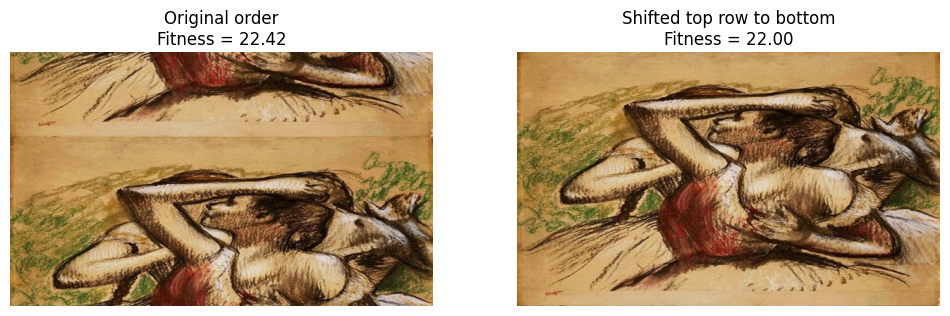

Original fitness: 22.41856412390431
Shifted fitness : 22.0


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# === Load ảnh refined ===
refined_path = r"output_data/refined_images/Edgar_Degas_477_shuffled.jpg_refined.png"
img_refined = Image.open(refined_path).convert("RGB")

# Cấu hình puzzle
ROWS, COLS = 3, 5
w_piece = img_refined.width // COLS
h_piece = img_refined.height // ROWS

# Cắt thành pieces
pieces = []
for r in range(ROWS):
    for c in range(COLS):
        left, upper = c*w_piece, r*h_piece
        right, lower = left + w_piece, upper + h_piece
        pieces.append(img_refined.crop((left, upper, right, lower)))

# === Fitness helper ===
def compute_fitness(order, pieces, rows, cols):
    H, V = compute_cost_matrix_advanced(pieces)
    grid = np.array(order).reshape(rows, cols)
    total = 0.0
    for r in range(rows):
        for c in range(cols):
            cur = grid[r, c]
            if c < cols - 1:
                total += H[cur, grid[r, c+1]]
            if r < rows - 1:
                total += V[cur, grid[r+1, c]]
    return total

def assemble(order, pieces, rows, cols):
    grid = np.array(order).reshape(rows, cols)
    w, h = pieces[0].size
    out = Image.new("RGB", (w*cols, h*rows))
    for r in range(rows):
        for c in range(cols):
            out.paste(pieces[grid[r, c]], (c*w, r*h))
    return out

# === Ban đầu: order mặc định 0..N-1 ===
n = ROWS*COLS
order_orig = list(range(n))
fitness_orig = compute_fitness(order_orig, pieces, ROWS, COLS)
img_orig = assemble(order_orig, pieces, ROWS, COLS)

# === Hoán đổi: đưa hàng 0 xuống cuối ===
grid = np.array(order_orig).reshape(ROWS, COLS)
grid_shifted = np.vstack([grid[1:], grid[0]])  # đẩy row0 xuống dưới
order_shifted = grid_shifted.reshape(-1).tolist()
fitness_shifted = compute_fitness(order_shifted, pieces, ROWS, COLS)
img_shifted = assemble(order_shifted, pieces, ROWS, COLS)

# === Hiển thị ===
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img_orig)
plt.title(f"Original order\nFitness = {fitness_orig:.2f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_shifted)
plt.title(f"Shifted top row to bottom\nFitness = {fitness_shifted:.2f}")
plt.axis("off")

plt.show()

print("Original fitness:", fitness_orig)
print("Shifted fitness :", fitness_shifted)
